# CMSC320 Final Project: How Well Does Spotify Recommend Music?
## Megan Nee

I've always been really interested in data and data analysis surrounding my Spotify listening data. Whenever a new app or website comes out that can tell you who your top artists are, or how obscure your music taste is, I'm always ready to try it. In my tutorial, I wanted to showcase my interest in music and utilize Spotify's web API to analyze my own listening data.  

Every year, Spotify releases a "Spotify Wrapped" where it gives you an overview of your top artists and songs from that year, and puts your top 100 songs in a playlist. I looked through my Spotify playlists and found that I have every one since 2016 saved.  

For this project, I decided to use the 2016, 2017, 2021, and 2022 playlists to explore the way my taste in music has changed over time. Using machine learning, I also wanted to see how good Spotify is at recommending tracks through their Discover Weekly and Release Radar playlists.

## Getting the Data

Spotify has a very well documented web API that you can utilize with the Python package spotipy. The full documentation can be found [here](https://spotipy.readthedocs.io/en/2.22.0/).  
First, I had to create a [Spotify developer account](https://developer.spotify.com/) and create a new app. From there, I got a client ID and client secret to use to authenticate my account. I stored these within an .env file and used python-dotenv to load them without exposing my credentials to the internet.

In [ ]:
%pip install spotipy
%pip install python-dotenv

import csv
import spotipy
import os
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyClientCredentials

load_dotenv('vars.env')

In [45]:
# Load the client secret from environment variables
client_id = os.environ['SPOTIPY_CLIENT_ID']
client_secret = os.environ['SPOTIPY_CLIENT_SECRET']

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

I then created dataframes of each of the playlists and include their audio features such as danceability, energy, tempo, etc. I did some research online and found a couple pre-written functions that I modified to get the features that I want. The call_playlist function below is using a for loop to go through each of the tracks in the playlist and then calling Spotipy API calls to get their audio features. I'll explain the Spotify track audio features a bit more later.

Playlist function referenced from [this article](https://towardsdatascience.com/how-to-create-large-music-datasets-using-spotipy-40e7242cc6a6).

In [46]:
import pandas as pd

In [47]:
def call_playlist(creator, playlist_id):
    
    #step1

    playlist_features_list = ["artist", "album", "track_name", "track_id", "genre", "popularity",
                              "duration_ms", "danceability", "valence", "energy", "tempo", "loudness", 
                              "speechiness", "instrumentalness", "liveness", "acousticness"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    #step2
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        playlist_features["popularity"] = track["track"]["popularity"]
        
        artist_uri = track["track"]["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri)
        
        if (artist_info["genres"]):
            playlist_features["genre"] = artist_info["genres"][0]
        else:
            playlist_features["genre"] = None
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[6:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

    #Step 3
        
    return playlist_df

In order to avoid manually going through to rate each song from 1-10, I am going to make this a classification problem instead. I know that the songs from 2021 and 2022 are my current music taste and the ones from 2016 and 2017 are much less. Therefore, I am going to rank each song at either 1 or 0 for songs I like and others.

In [48]:
top22 = call_playlist("mlnee", "1LX2YGoVLvzSeoCIloxAfO")
top22["rating"] = 1

In [49]:
top21 = call_playlist("mlnee", "575crUuhYbRPtZVvmWzLiW")
top21["rating"] = 1

In [50]:
top17 = call_playlist("mlnee", "37i9dQZF1E9RZdr9sb7A6W")
top17["rating"] = 0

In [51]:
top16 = call_playlist("mlnee", "37i9dQZF1CyNE3u4Gr5JxR")
top16["rating"] = 0

In [52]:
# Concat all of the playlists
top_playlists = pd.concat([top22, top21])
top_playlists = pd.concat([top_playlists, top17])
top_playlists = pd.concat([top_playlists, top16])

# Dropping duplicate tracks
top_playlists = top_playlists.drop_duplicates(subset="track_id", keep="first")

In [53]:
top_playlists.to_csv("MyData/top_playlists", index=False)

Here I am creating a dataframe of recommendations that Spotify gives me through their Discover Weekly and Release Radar playlists to use later.

In [54]:
recommendations = call_playlist("mlnee", "4ntsmAipoBpDYGr9k01NT5")
recommendations = recommendations.drop_duplicates(subset="track_id", keep="first")

In [55]:
recommendations.to_csv("MyData/recommendations", index=False)

If you're following this tutorial, you can either reference the code above to use your own Spotify data, or you can find these datasets [here](https://github.com/mlnee/mlnee.github.io/tree/main/MyData).

## Data Exploration

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [57]:
# Drop any missing values
top_playlists.dropna()

# Set columns to correct types
top_playlists = top_playlists.astype({'popularity':'int','genre':'str','duration_ms':'int','danceability':'float',
                                      'valence':'float','energy':'float','tempo':'float','loudness':'float',
                                      'speechiness':'float','instrumentalness':'float','liveness':'float',
                                     'acousticness':'float'})
top_playlists.head()

,artist,album,track_name,track_id,genre,popularity,duration_ms,danceability,valence,energy,tempo,loudness,speechiness,instrumentalness,liveness,acousticness,rating
0,The Weeknd,Dawn FM,Is There Someone Else?,0mL82sxCRjrs3br407IdJh,canadian contemporary r&b,84,199111,0.702,0.608,0.586,134.951,-7.830,0.0313,0.000073,0.1560,0.0388,1
1,The Weeknd,Dawn FM,"Here We Go… Again (feat. Tyler, the Creator)",1NhjYYcYTRywc0di98xHxf,canadian contemporary r&b,70,209778,0.469,0.198,0.623,134.943,-4.432,0.0302,0.000000,0.5880,0.3450,1
2,Father John Misty,Pure Comedy,Pure Comedy,0HbFgNSVPMfZLXcmkm5Q42,chamber pop,41,383800,0.463,0.157,0.262,130.228,-11.655,0.0404,0.000000,0.2150,0.8160,1
3,Rina Sawayama,SAWAYAMA,XS,1TWNKyNQOBfNUkWWs7FooF,art pop,62,201060,0.635,0.590,0.929,117.039,-3.256,0.1460,0.000001,0.0822,0.0854,1
4,Kate Bush,Hounds of Love (2018 Remaster),Hounds Of Love - 2018 Remaster,7Gmds7ZyvhKdoU0Ho4GIxK,art pop,52,182867,0.543,0.928,0.795,145.523,-12.769,0.0394,0.000003,0.2000,0.4980,1


First, let's compare the popularity and genre for both ratings.

In [58]:
# Get frequency count of top 5 genres from both ratings
topgenre0 = top_playlists.query('rating==0')['genre'].value_counts().head()
topgenre1 = top_playlists.query('rating==1')['genre'].value_counts().head()

print('Top 5 genres from 2016-2017')
print(topgenre0)
print()
print('Top 5 genres from 2021-2022')
print(topgenre1)

Top 5 genres from 2016-2017
dance pop         48
post-teen pop     16
alt z             16
boy band          11
australian pop     9
Name: genre, dtype: int64

Top 5 genres from 2021-2022
art pop                      28
pop                          13
canadian contemporary r&b    12
bedroom pop                   8
afrofuturism                  8
Name: genre, dtype: int64


In [59]:
# Get number of unique genres in each rating
numgenre0 = top_playlists.query('rating==0')['genre'].nunique()
numgenre1 = top_playlists.query('rating==1')['genre'].nunique()

print('Number of unique genres from 2016-2017: ', numgenre0)
print('Number of unique genres from 2021-2022: ', numgenre1)

Number of unique genres from 2016-2017:  39
Number of unique genres from 2021-2022:  65


Here, you can see how my taste in genre has changed and how much it has diversified, going from 39 unique genres to 64.

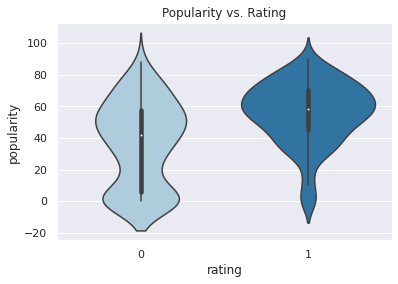

In [60]:
ax = sns.violinplot(data=top_playlists, x='rating', y='popularity', palette='Paired')
ax.set_title("Popularity vs. Rating")
plt.show()

According to Spotify API documentation, "the popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past." The violin plot makes sense after reading this, because songs I was listening to in 2016-2017 were probably popular at the time, but less so now. This explains the distribution on the 0 rating songs being more skewed upwards and also being bimodal. The lower peak is around 0 popularity. The 1 rated songs are more popular right now with a clear peak around 60 popularity and a much smaller peak around 0.  

Through this plot, I can infer that the tracks that I am listening to right now are decently popular with a few that are more underground.

Spotify splits its features by mood (danceability, valence, energy, and tempo), properties (loudness, speechiness, instrumentalness), and context (liveness, acousticness). The features that are most interesting to me are the ones related to mood, so I will do some exploratory data analysis and visualizations of those.  

The Spotify web API defines these features in the [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) as follows:  
- Danceability: "describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."
- Valence: "a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)."
- Energy: "a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy."
- Tempo: "overall estimated tempo of a track in beats per minute (BPM)."

I want to compare these features between my 0 and 1 rated songs.

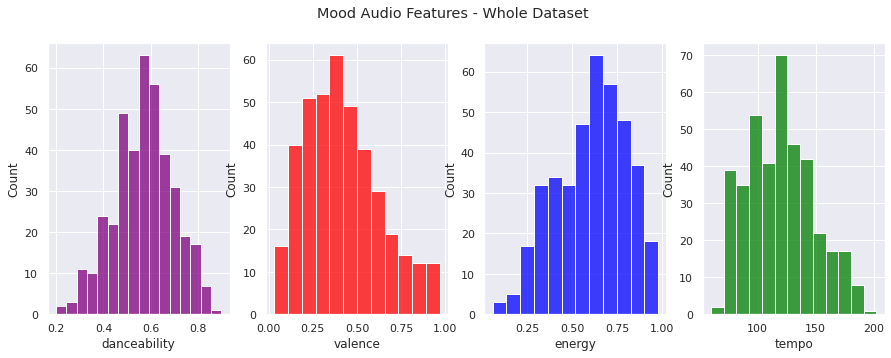

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Mood Audio Features - Whole Dataset")

sns.histplot(ax=axes[0], data=top_playlists.danceability, color="purple")
sns.histplot(ax=axes[1], data=top_playlists.valence, color="red")
sns.histplot(ax=axes[2], data=top_playlists.energy, color="blue")
sns.histplot(ax=axes[3], data=top_playlists.tempo, color="green")
plt.show()

Here, we can see there is correlation between all of these features. Danceability and energy, and valence and tempo are positively correlated. This makes a lot of sense, because as energy of a track goes up, it becomes more danceable; and as the tempo decreases, the valence is lower because songs become slower and more sad.  

In this visualization of the audio features for the whole dataset, it's clear that the tracks lean towards a lower valence and a higher energy. Danceability is pretty evenly distributed around the 0.5 mark.

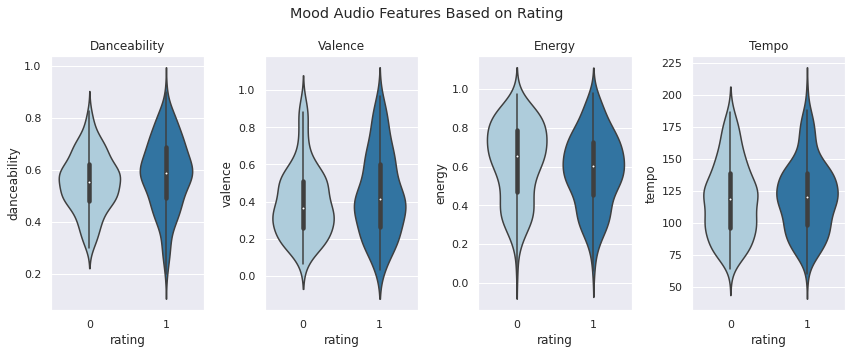

In [62]:
# Plot each of the audio features split by rating
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle("Mood Audio Features Based on Rating")

sns.violinplot(ax = axes[0], data=top_playlists, x='rating', y='danceability', palette='Paired')
axes[0].set_title("Danceability")

sns.violinplot(ax = axes[1], data=top_playlists, x='rating', y='valence', palette='Paired')
axes[1].set_title("Valence")

sns.violinplot(ax = axes[2], data=top_playlists, x='rating', y='energy', palette='Paired')
axes[2].set_title("Energy")

sns.violinplot(ax = axes[3], data=top_playlists, x='rating', y='tempo', palette='Paired')
axes[3].set_title("Tempo")

plt.tight_layout()
plt.show()

Here, I wanted to compare these features by their ratings. Through these violin plots, we can see that the danceability of the tracks have slightly increased and the spread has also increased, with the values spanning the whole range from 0 to 1. We can also see that the valence has increased slightly, again with a higher spread and more broad distribution. Energy has gone slightly down, with a more normalized distribution around the mean for the rating of 1 compared to the rating of 0. Average tempo has stayed approximately the same but with a narrower distribution. These comparisons will be helpful when we want to determine the ratings for the recommended tracks.  

The broader distribution of these audio features makes sense when thinking about the increase in genres that I am listening to. With a greater number of genres, there's a big difference in the moods that the tracks bring.

## Hypothesis Testing

Hypothesis testing is an important part of data science to decide if a theory that we hold is true or not. In this case, my theory is that there's a correlation between some of the track and audio features and the ratings that I give them (aka what songs I currently like). We can try to prove this by performing statistical tests.

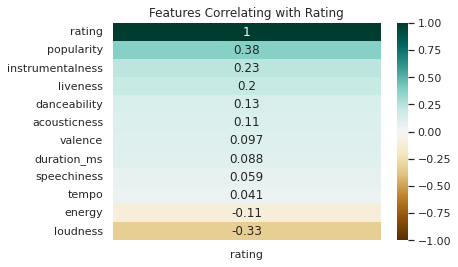

In [63]:
# Create a heatmap to show the correlation coefficients of each feature to the rating
ax = sns.heatmap(top_playlists.corr()[['rating']].sort_values(by='rating', ascending=False), vmin=-1, 
                 vmax=1, annot=True, cmap='BrBG')
ax.set_title('Features Correlating with Rating')

plt.show()

This heatmap shows the correlation of the track and audio features with the rating. Since the correlation is pretty low, I am going to consider anything > 0.1 and < -0.1 a good correlation coefficient. This means I am hypothesizing that popularity, instrumentalness, liveness, danceability, and acousticness are all features that positively correlate with my rating. Energy and loudness are features that negatively correlate with my rating.

Since we are comparing a categorical variable (rating) with a continuous variable, we should use the logistic regression model. Logistic regression analysis is used to evaluate the relationship between independent continuous variables and a binary dependent variable. Read more about logistic regression [here](https://www.statisticssolutions.com/logistic-regression/)

In [64]:
import statsmodels.api as sm

# defining the dependent and independent variables
Xtrain = top_playlists[["popularity", "danceability", "energy", "loudness", 
                              "instrumentalness", "liveness", "acousticness"]]
ytrain = top_playlists[['rating']]
  
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.533425
         Iterations 12


In [65]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:                  394
Model:                          Logit   Df Residuals:                      387
Method:                           MLE   Df Model:                            6
Date:                Fri, 16 Dec 2022   Pseudo R-squ.:                  0.2304
Time:                        21:46:48   Log-Likelihood:                -210.17
converged:                       True   LL-Null:                       -273.08
Covariance Type:            nonrobust   LLR p-value:                 9.740e-25
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
popularity           0.0274      0.005      5.348      0.000       0.017       0.037
danceability         0.0022      0.876      0.003      0.998      -1.715       1.719
energy              -3.2562      0.671     -4.856      0.000      -4.570      -1.942
loudness            -0.0658      0.055     -1.194      0.233      -0.174       0.042
instrumentalness   143.6320     49.918      2.877      0.004      45.795     241.469
liveness             2.7287      1.026      2.660      0.008       0.718       4.739
acousticness        -1.5441      0.538     -2.870      0.004      -2.598      -0.490
====================================================================================
"""

After fitting the logistic regression model to our data, we can see that the p-values for most of the features that we hypothesized were good coefficients are less than 0.05 which means that they are statistically significant in our model. Danceability and loudness had p-values > 0.05 which means that they are not correlated with the ratings and we cannot reject the null hypothesis.

In [66]:
# defining the dependent and independent variables
Xtrain = top_playlists[["popularity", "energy", "instrumentalness", "liveness", "acousticness"]]
ytrain = top_playlists[['rating']].values.flatten()

Now, we can run a logistic regression cross-validation classifier from scikit learn to train our model and use it to predict which recommended songs would get a rating of 1. We'll only use the features that were statistically significant, so we'll take out danceability and loudness.

In [67]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic regression run with stratified k-folds where k=5
clf = LogisticRegressionCV(cv=5, random_state=0).fit(Xtrain, ytrain)
clf.score(Xtrain, ytrain)

0.7258883248730964

The score above shows that there is a 72.6% accuracy for the model on predicting the training data, which is just ok. The score is probably lower because there isn't an extremely distinct correlation between the training set features and ratings. However, the score is still decent, so we can use it to predict the ratings of the recommendation set.

In [68]:
Xtest = recommendations[["popularity", "energy", "instrumentalness", "liveness", "acousticness"]]

# Use the logistic regression model to predict ratings for the recommendation set
predictions = clf.predict(Xtest)
recommendations['pred_ratings'] = predictions

# Print all recommendations with a rating of 1
recommendations.query('pred_ratings==1')

,artist,album,track_name,track_id,genre,popularity,duration_ms,danceability,valence,energy,tempo,loudness,speechiness,instrumentalness,liveness,acousticness,pred_ratings
0,Clairo,Sling,Amoeba,0HAqq2GcQKyi3s87GuN7jU,bedroom pop,72,228922,0.739,0.707,0.491,111.008,-11.515,0.027,0.0366,0.1,0.791,1
1,Kenny Beats,LOUIE,Still,2rbSlNYTYboHHWelF0xSAQ,hip hop,55,162240,0.619,0.84,0.702,140.854,-7.847,0.124,0.0531,0.174,0.185,1
2,Shelly,Shelly,Steeeam,09RamrocZneYcLYLRIxYha,indie pop,62,170893,0.817,0.923,0.763,120.034,-11.014,0.0373,0.158,0.124,0.546,1
3,Ryan Beatty,Boy in Jeans,Party's Over,16v5heGSXbMLE2gV1oRfwi,bedroom soul,35,245178,0.322,0.152,0.315,137.861,-9.422,0.0298,0.000021,0.376,0.7,1
5,Car Seat Headrest,Commit Yourself Completely,"Ivy - Live at the Capitol Theater, Olympia, WA",4MwhlxglzBBnuPrSYQcy1N,alternative rock,40,311313,0.707,0.499,0.16,102.14,-13.678,0.0634,0.000018,0.946,0.92,1
7,Little Simz,Sometimes I Might Be Introvert,Protect My Energy,64DqILfBnCXzhEDGUHZet1,alternative r&b,48,188800,0.73,0.963,0.82,115.015,-7.458,0.0315,0.44,0.102,0.00478,1
8,Turnstile,GLOW ON,ALIEN LOVE CALL,5o5SdS2vu1PgKblBABGlER,hardcore punk,59,176003,0.548,0.0732,0.401,126.041,-9.376,0.0307,0.0078,0.184,0.00282,1
9,underscores,fishmonger,Del mar county fair 2008,7HTdY4rpT1Wal6ux3t2hE4,escape room,40,271111,0.712,0.529,0.3,134.917,-11.276,0.063,0.000063,0.419,0.874,1
12,Remi Wolf,Live at Electric Lady,Pink + White - Live at Electric Lady,5uJK1i4LU4I5Ai5qCeHonu,indie pop,62,233407,0.498,0.55,0.468,148.266,-6.17,0.0502,0,0.103,0.133,1
13,Ball Park Music,Ball Park Music,"Bad Taste Blues, Pt. III",5X4GIF87F0PzUUSTA2TIR4,australian indie,47,258093,0.49,0.522,0.652,108.943,-6.374,0.0315,0.105,0.127,0.0168,1


Let's see how many of the recommended songs were given a rating of 1.

In [69]:
recommendations['pred_ratings'].value_counts(normalize=True) * 100

1    65.0
0    35.0
Name: pred_ratings, dtype: float64

65% of the recommendation dataset was given a predicted rating of 1 which is a decent score. According to my current taste in music, this is showing that the model predicts that I will like 65% of the songs. This could mean two different things: my model is not very accurate, or Spotify puts songs that are possibly more of a wildcard into their recommended playlists.

## Conclusion

After exploring my Spotify playlists, and comparing my old top songs to my new ones, I was able to see that there isn't a huge difference in the different mood audio features that I enjoy, even though the genres that I listen to have diversified a lot. I was also able to see that Spotify is decently good at recommending songs that it thinks I will enjoy based on a logistic regression model that was fitted to my data.  

It would be interesting to explore this more by changing the dataset to use my favorite playlists compared to random playlists that I pull off of Spotify. It would also be interesting to see how I could compare my listening taste to someone else's. A reason why my model was less accurate is because all of the data that I was using came from songs that I listen to now or have listened to before a lot. I would like to see if the accuracy increased if I rated tracks that I listen to more strictly. I would also be interested in putting more time into this project to see if rating each song from 1-10 would allow for a more accurate model.